<a href="https://colab.research.google.com/github/Andre-Vitor/Projetos-Data-Science/blob/main/California_Housing_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
# PKM

IMAGES_PATH = os.path.join('.', "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

O objetivo é prever o preço de uma casa.

# Descrição do dataset:
California Housing Price
O dataset é uma versão do repositório StatLib, modificado por Aurelién. Os dados são do censo de 1990 para o estado da Califórnia nos Estados Unidos.
O dataset contém algumas métricas, como a população, salário médio e preço mediano das casas por cada bloco na Califórnia. Um bloco é a menor unidade geográfica que a Secretaria do Censo dos Estados Unidos considera, normalmente entre 600 e 3000 pessoas. 

O objetivo do modelo é prever o preço mediano em um bloco, dados as outras métricas.

In [ ]:
!pip install pycaret

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [18]:
!pip install shap

  Using cached shap-0.39.0.tar.gz (356 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491645 sha256=285c617780a3df0e4a4cf6fcd841f288384445039ef98311ba201311846addb4
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [1]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

Imports e ler o dataset

In [164]:
#Imports
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_csv(os.path.join(HOUSING_PATH, "housing.csv"))

In [4]:
df

longitude  latitude  ...  median_house_value  ocean_proximity
0        -122.23     37.88  ...            452600.0         NEAR BAY
1        -122.22     37.86  ...            358500.0         NEAR BAY
2        -122.24     37.85  ...            352100.0         NEAR BAY
3        -122.25     37.85  ...            341300.0         NEAR BAY
4        -122.25     37.85  ...            342200.0         NEAR BAY
...          ...       ...  ...                 ...              ...
20635    -121.09     39.48  ...             78100.0           INLAND
20636    -121.21     39.49  ...             77100.0           INLAND
20637    -121.22     39.43  ...             92300.0           INLAND
20638    -121.32     39.43  ...             84700.0           INLAND
20639    -121.24     39.37  ...             89400.0           INLAND

[20640 rows x 10 columns]

Verificando os valores

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Estão faltando dados em total_bedrooms .

In [6]:
df.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

In [7]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
profile.to_file(output_file="Dataset_Profile.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

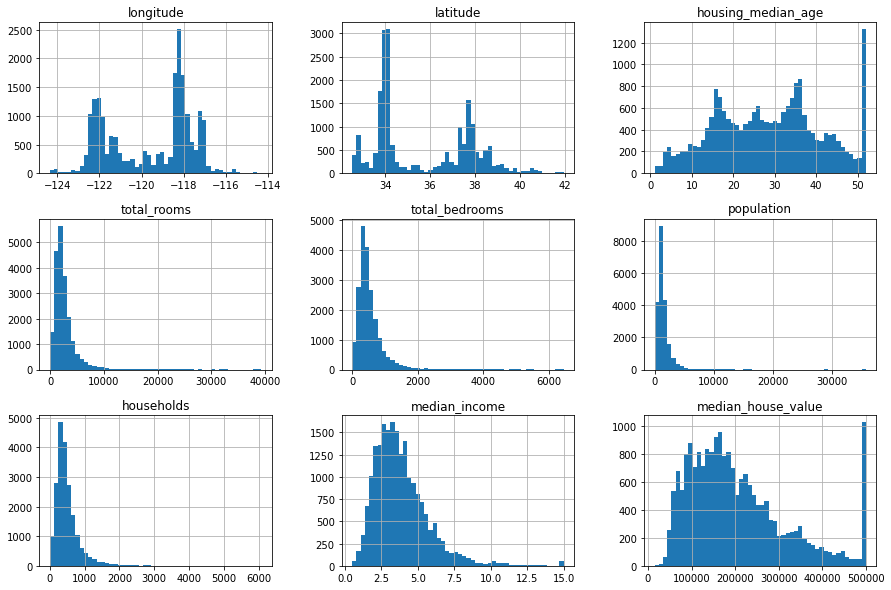

In [9]:
df.hist(bins=50,figsize=(15,10))
plt.show()

- O salário médio é em dezenas de milhares de dólares, ou seja , 1 na verdade é $10,000. 

Vamos criar um baseline para os modelos com PyCaret.

In [10]:
from pycaret.regression import *

In [29]:
classifier = setup(data=df, target='median_house_value')
best_models = compare_models(n_select=5)
best_model =  tune_model(best_models[0])
final_model = finalize_model(best_model)

MAE           MSE        RMSE      R2   RMSLE    MAPE
0     30173.8647  2.268418e+09  47627.9073  0.8364  0.2359  0.1682
1     31244.8565  2.147072e+09  46336.5122  0.8373  0.2281  0.1704
2     30311.2202  2.044851e+09  45220.0254  0.8526  0.2314  0.1716
3     30589.6196  2.168823e+09  46570.6269  0.8462  0.2283  0.1666
4     29925.8572  1.938398e+09  44027.2391  0.8569  0.2290  0.1709
5     30663.4610  2.359754e+09  48577.3039  0.8266  0.2427  0.1783
6     29710.2446  2.000766e+09  44729.9197  0.8476  0.2334  0.1683
7     31339.7748  2.231809e+09  47242.0235  0.8337  0.2341  0.1733
8     31214.8180  2.330072e+09  48270.8177  0.8182  0.2328  0.1707
9     29947.3975  2.013354e+09  44870.4154  0.8434  0.2232  0.1662
Mean  30512.1114  2.150332e+09  46347.2791  0.8399  0.2319  0.1705
SD      566.1278  1.393825e+08   1503.7903  0.0112  0.0050  0.0034

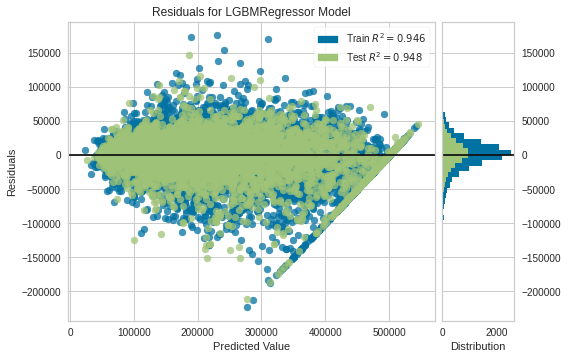

In [30]:
plot_model(final_model)

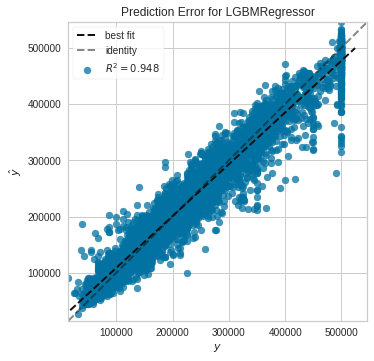

In [31]:
plot_model(final_model, plot = 'error')

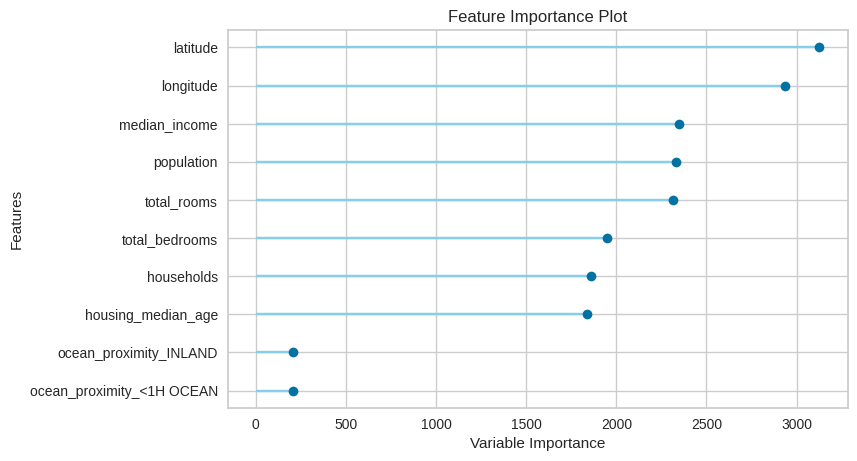

In [32]:
plot_model(final_model, plot = 'feature')

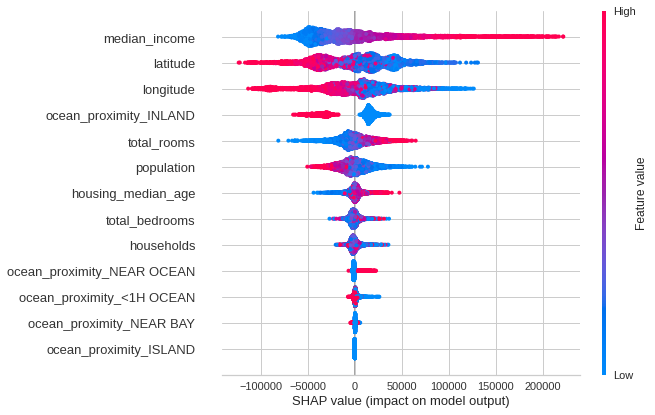

In [33]:
interpret_model(final_model)

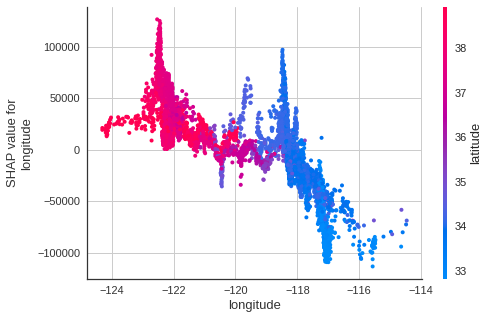

In [34]:
interpret_model(final_model, plot = 'correlation')

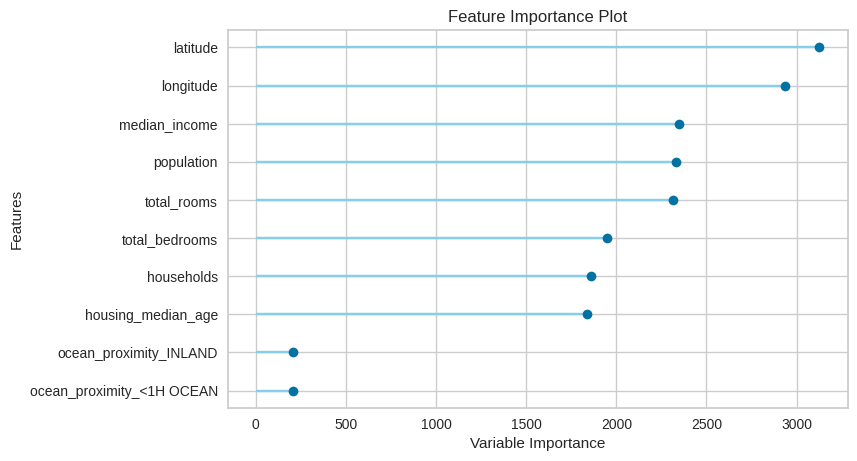

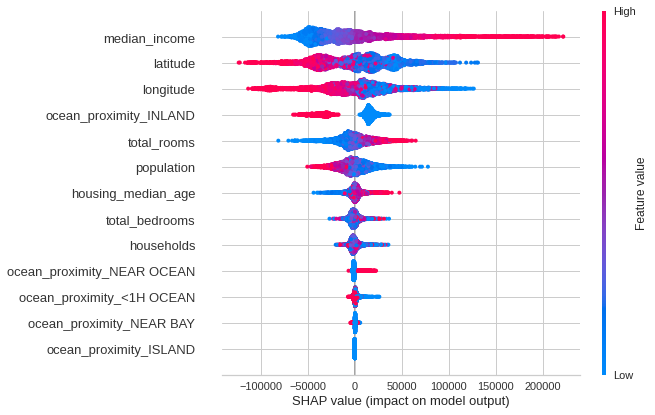

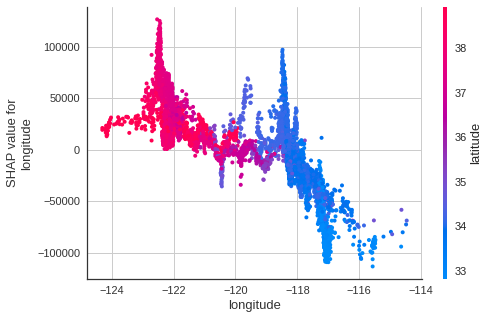

In [35]:
plot_model(final_model)
plot_model(final_model, plot = 'error')
plot_model(final_model, plot = 'feature')
interpret_model(final_model)
interpret_model(final_model, plot = 'correlation')


# Exploratory Data Analysis

Saving figure housing_prices_scatterplot


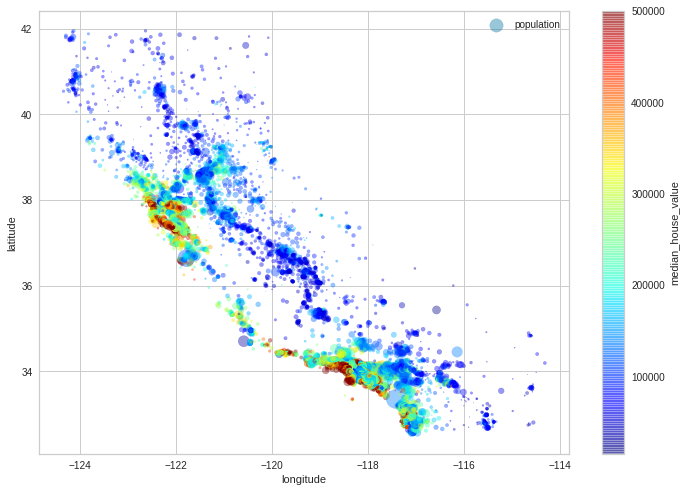

In [52]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=df["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

## Observações:
Pode-se notar que as casas mais caras estão próximas do oceano. Não é tão válido para as casas ao norte.

In [72]:
x = pd.cut(df['median_income'],bins=5)
x

0          (6.3, 9.2]
1          (6.3, 9.2]
2          (6.3, 9.2]
3          (3.4, 6.3]
4          (3.4, 6.3]
             ...     
20635    (0.485, 3.4]
20636    (0.485, 3.4]
20637    (0.485, 3.4]
20638    (0.485, 3.4]
20639    (0.485, 3.4]
Name: median_income, Length: 20640, dtype: category
Categories (5, interval[float64]): [(0.485, 3.4] < (3.4, 6.3] < (6.3, 9.2] < (9.2, 12.1] <
                                    (12.1, 15.0]]

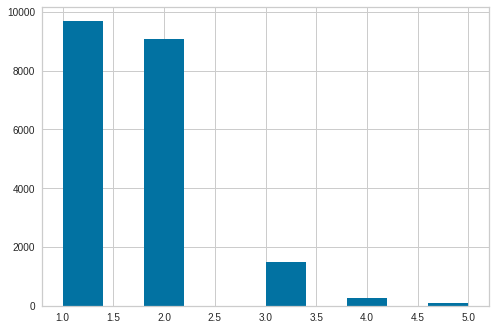

In [71]:
x.hist()

## Correlações e heatmap

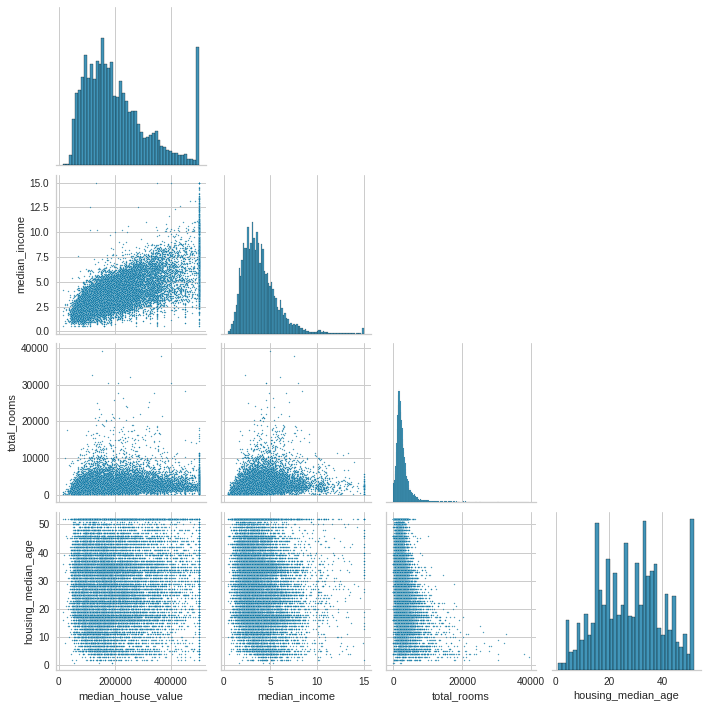

In [95]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
sns.pairplot(df[attributes], corner=True, plot_kws={'alpha':0.7, 's':2})

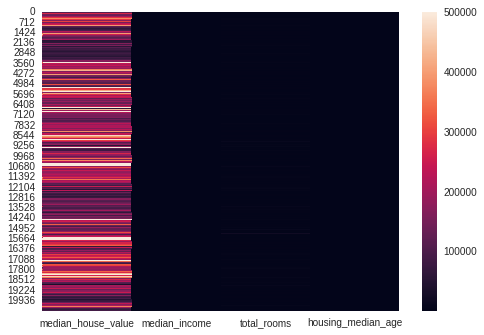

In [97]:
sns.heatmap(data=df[attributes])

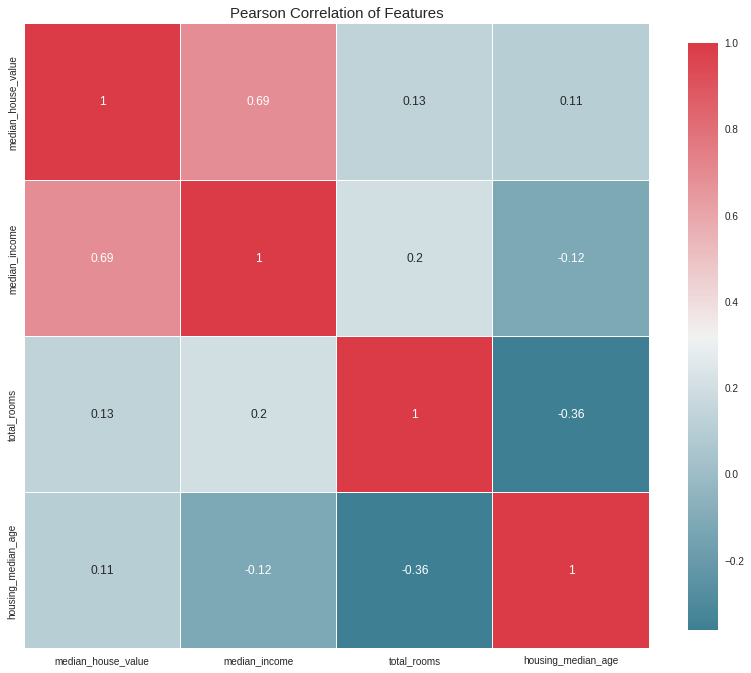

In [99]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df[attributes])

# Criando novas colunas

In [ ]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]=df["population"]/df["households"]

# Preparando os dados

In [107]:
df_original = df.drop('median_house_value', axis=1)
df_labels = df['median_house_value'].copy()

Precisamos separar os atributos numéricos dos categóricos.
Primeiramente vamos substituir os valores faltantes pela mediana.

In [110]:
df_numerical = df.select_dtypes(include=[np.number])
df_categorical = df.select_dtypes(include=['object'])

In [114]:
df_numerical.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')

In [115]:
df_categorical.columns

Index(['ocean_proximity'], dtype='object')

Vamos agora lidar com o atributo categórico ocean_proximity

In [118]:
df_categorical.sample(5)

ocean_proximity
10193       <1H OCEAN
9068           INLAND
11175       <1H OCEAN
12087          INLAND
20136       <1H OCEAN

In [120]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
onehot = encoder.fit_transform(df_categorical)
onehot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [121]:
# Verificando as categorias
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Pipeline

In [145]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

df_numerical = num_pipeline.fit_transform(df_numerical)

In [146]:
df_numerical

array([[-1.32783522,  1.05254828,  0.98214266, ..., -0.97703285,
         2.34476576,  2.12963148],
       [-1.32284391,  1.04318455, -0.60701891, ...,  1.66996103,
         2.33223796,  1.31415614],
       [-1.33282653,  1.03850269,  1.85618152, ..., -0.84363692,
         1.7826994 ,  1.25869341],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.17404163,
        -1.14259331, -0.99274649],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.39375258,
        -1.05458292, -1.05860847],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.07967221,
        -0.78012947, -1.01787803]])

In [147]:
categorical_pipeline = Pipeline([
        ('onehot',OneHotEncoder()),
    ])

In [148]:
from sklearn.compose import ColumnTransformer

numerical_attributes = list(df.select_dtypes(include=[np.number]))
categorical_attributes = list(df.select_dtypes(include=['object']))

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_attributes),
        ("cat", OneHotEncoder(), categorical_attributes),
    ])

df_prepared = full_pipeline.fit_transform(df)

In [151]:
df_prepared.shape

(20640, 14)

In [152]:
temp = pd.DataFrame(df_prepared)

In [153]:
temp

0         1         2         3   ...   10   11   12   13
0     -1.327835  1.052548  0.982143 -0.804819  ...  0.0  0.0  1.0  0.0
1     -1.322844  1.043185 -0.607019  2.045890  ...  0.0  0.0  1.0  0.0
2     -1.332827  1.038503  1.856182 -0.535746  ...  0.0  0.0  1.0  0.0
3     -1.337818  1.038503  1.856182 -0.624215  ...  0.0  0.0  1.0  0.0
4     -1.337818  1.038503  1.856182 -0.462404  ...  0.0  0.0  1.0  0.0
...         ...       ...       ...       ...  ...  ...  ...  ...  ...
20635 -0.758826  1.801647 -0.289187 -0.444985  ...  1.0  0.0  0.0  0.0
20636 -0.818722  1.806329 -0.845393 -0.888704  ...  1.0  0.0  0.0  0.0
20637 -0.823713  1.778237 -0.924851 -0.174995  ...  1.0  0.0  0.0  0.0
20638 -0.873626  1.778237 -0.845393 -0.355600  ...  1.0  0.0  0.0  0.0
20639 -0.833696  1.750146 -1.004309  0.068408  ...  1.0  0.0  0.0  0.0

[20640 rows x 14 columns]

# Separando em treino e teste:

In [36]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, train_size=0.8, random_state=42)

0          (6.3, 9.2]
1          (6.3, 9.2]
2          (6.3, 9.2]
3          (3.4, 6.3]
4          (3.4, 6.3]
             ...     
20635    (0.485, 3.4]
20636    (0.485, 3.4]
20637    (0.485, 3.4]
20638    (0.485, 3.4]
20639    (0.485, 3.4]
Name: median_income, Length: 20640, dtype: category
Categories (5, interval[float64]): [(0.485, 3.4] < (3.4, 6.3] < (6.3, 9.2] < (9.2, 12.1] <
                                    (12.1, 15.0]]

In [154]:
X = pd.DataFrame(
    {'city': ['London', 'London', 'Paris', 'Sallisaw'],
     'title': ["His Last Bow", "How Watson Learned the Trick",
               "A Moveable Feast", "The Grapes of Wrath"],
     'expert_rating': [5, 3, 4, 5],
     'user_rating': [4, 5, 4, 3]})

In [160]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
ct = ColumnTransformer([
      ('scale', StandardScaler(),
      make_column_selector(dtype_include=np.number)),
      ('onehot',
      OneHotEncoder(),
      make_column_selector(pattern='city', dtype_include=object))])
ct.fit_transform(X)

array([[ 0.90453403,  0.        ,  1.        ,  0.        ,  0.        ],
       [-1.50755672,  1.41421356,  1.        ,  0.        ,  0.        ],
       [-0.30151134,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.90453403, -1.41421356,  0.        ,  0.        ,  1.        ]])

In [161]:
from sklearn import set_config
set_config(display='diagram')   
# diplays HTML representation in a jupyter context
column_trans  

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('city_category',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype='int',
                                               handle_unknown='error',
                                               sparse=True),
                                 ['city']),
                                ('title_bow',
                                 CountVectorizer(analyzer='word', binary=False,
                                                 decode_error='strict',
                                                 dtype=<class 'numpy.int64'>,
                                                 encoding='utf-8',
                                                 input='content',
                                                 lowercase=True, max_df=1.0,
                                                 max_features=None, min_df=1,
                                                 ngram_range=(1, 1),
                                                 preprocessor=None,
                                                 stop_words=None,
                                                 strip_accents=None,
                                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                                 tokenizer=None,
                                                 vocabulary=None),
                                 'title')],
                  verbose=False)

In [163]:
ct.get_feature_names()

AttributeError: ignored

# AutoML com PyCaret

In [122]:
classifier = setup(data=df, target='median_house_value',silent=True)

Description               Value
0                               session_id                8924
1                                   Target  median_house_value
2                            Original Data         (20640, 10)
3                           Missing Values                True
4                         Numeric Features                   8
5                     Categorical Features                   1
6                         Ordinal Features               False
7                High Cardinality Features               False
8                  High Cardinality Method                None
9                    Transformed Train Set         (14447, 13)
10                    Transformed Test Set          (6193, 13)
11                      Shuffle Train-Test                True
12                     Stratify Train-Test               False
13                          Fold Generator               KFold
14                             Fold Number                  10
15                                CPU Jobs                  -1
16                                 Use GPU               False
17                          Log Experiment               False
18                         Experiment Name    reg-default-name
19                                     USI                f26c
20                         Imputation Type              simple
21          Iterative Imputation Iteration                None
22                         Numeric Imputer                mean
23      Iterative Imputation Numeric Model                None
24                     Categorical Imputer            constant
25  Iterative Imputation Categorical Model                None
26           Unknown Categoricals Handling      least_frequent
27                               Normalize               False
28                        Normalize Method                None
29                          Transformation               False
30                   Transformation Method                None
31                                     PCA               False
32                              PCA Method                None
33                          PCA Components                None
34                     Ignore Low Variance               False
35                     Combine Rare Levels               False
36                    Rare Level Threshold                None
37                         Numeric Binning               False
38                         Remove Outliers               False
39                      Outliers Threshold                None
40                Remove Multicollinearity               False
41             Multicollinearity Threshold                None
42             Remove Perfect Collinearity                True
43                              Clustering               False
44                    Clustering Iteration                None
45                     Polynomial Features               False
46                       Polynomial Degree                None
47                    Trignometry Features               False
48                    Polynomial Threshold                None
49                          Group Features               False
50                       Feature Selection               False
51                Feature Selection Method             classic
52            Features Selection Threshold                None
53                     Feature Interaction               False
54                           Feature Ratio               False
55                   Interaction Threshold                None
56                        Transform Target               False
57                 Transform Target Method             box-cox

In [124]:
compare_models(include=['lightgbm'])

Model         MAE           MSE  \
lightgbm  Light Gradient Boosting Machine  32170.9713  2.320708e+09   

                RMSE      R2   RMSLE    MAPE  TT (Sec)  
lightgbm  48139.7849  0.8251  0.2399  0.1817     0.481

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=8924, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [137]:
def test_new_data(df,target):
    predict_model(final_model)
    print('\n')
    classifier = setup(data=df, target=target,silent=True)
    lightgbm = create_model('lightgbm')
    tuned_lightgbm = tune_model(lightgbm, n_iter=50, optimize = 'MSE')
    predict_model(tuned_lightgbm)
    print('\n')



In [101]:
best_models = compare_models(n_select=5)

Model          MAE           MSE  \
lightgbm  Light Gradient Boosting Machine   32052.1865  2.296739e+09   
rf                Random Forest Regressor   32364.3387  2.464337e+09   
et                  Extra Trees Regressor   34982.4747  2.769336e+09   
gbr           Gradient Boosting Regressor   38250.0622  3.037286e+09   
dt                Decision Tree Regressor   43551.6480  4.729725e+09   
lr                      Linear Regression   50008.8859  4.773936e+09   
lasso                    Lasso Regression   50008.7051  4.773932e+09   
ridge                    Ridge Regression   50009.4383  4.773878e+09   
lar                Least Angle Regression   50008.8574  4.773935e+09   
br                         Bayesian Ridge   50017.7066  4.774970e+09   
llar         Lasso Least Angle Regression   49999.4219  4.774387e+09   
en                            Elastic Net   52731.2648  5.156519e+09   
huber                     Huber Regressor   54674.6240  5.853571e+09   
omp           Orthogonal Matching Pursuit   62834.8580  7.052225e+09   
ada                    AdaBoost Regressor   79106.7414  8.512051e+09   
knn                 K Neighbors Regressor   76774.8609  9.894507e+09   
par          Passive Aggressive Regressor  160991.8334  8.212089e+10   

                 RMSE      R2   RMSLE    MAPE  TT (Sec)  
lightgbm   47908.7215  0.8286  0.2350  0.1788     0.238  
rf         49608.8744  0.8161  0.2387  0.1800     7.034  
et         52598.6135  0.7934  0.2509  0.1943     3.046  
gbr        55092.1789  0.7734  0.2687  0.2145     2.052  
dt         68720.8641  0.6472  0.3210  0.2357     0.133  
lr         69072.5242  0.6435  0.3787  0.2868     0.259  
lasso      69072.4672  0.6435  0.3787  0.2868     0.095  
ridge      69071.9820  0.6435  0.3787  0.2868     0.016  
lar        69072.5123  0.6435  0.3787  0.2868     0.018  
br         69079.7572  0.6435  0.3788  0.2869     0.021  
llar       69075.7003  0.6435  0.3762  0.2861     0.018  
en         71789.8484  0.6149  0.3697  0.3171     0.082  
huber      76494.3420  0.5629  0.4049  0.3025     0.204  
omp        83946.5637  0.4742  0.4266  0.3856     0.017  
ada        92217.9323  0.3648  0.4830  0.5379     0.886  
knn        99461.9414  0.2617  0.5189  0.5029     0.078  
par       219195.4563 -5.1521  0.9938  0.9026     0.071

In [102]:
best_model =  tune_model(best_models[0])

MAE           MSE        RMSE      R2   RMSLE    MAPE
0     29759.2751  2.047874e+09  45253.4393  0.8524  0.2222  0.1669
1     29135.5254  2.012498e+09  44860.8709  0.8522  0.2124  0.1574
2     28988.7823  1.943904e+09  44089.7263  0.8470  0.2072  0.1548
3     29733.1535  1.995428e+09  44670.2171  0.8367  0.2195  0.1648
4     30803.8023  2.171965e+09  46604.3417  0.8402  0.2207  0.1666
5     29963.0868  2.030728e+09  45063.5980  0.8465  0.2194  0.1610
6     29177.6372  1.992237e+09  44634.4776  0.8555  0.2279  0.1675
7     30712.0161  2.368537e+09  48667.6195  0.8248  0.2504  0.1804
8     30006.4601  1.991691e+09  44628.3604  0.8593  0.2153  0.1603
9     30241.6681  2.020206e+09  44946.7039  0.8498  0.2326  0.1755
Mean  29852.1407  2.057507e+09  45341.9355  0.8465  0.2228  0.1655
SD      597.4582  1.180758e+08   1271.0506  0.0096  0.0115  0.0075

In [ ]:
final_model = finalize_model(best_model)

In [103]:
classifier = setup(data=df, target='median_house_value')

Description               Value
0                               session_id                3948
1                                   Target  median_house_value
2                            Original Data         (20640, 10)
3                           Missing Values                True
4                         Numeric Features                   8
5                     Categorical Features                   1
6                         Ordinal Features               False
7                High Cardinality Features               False
8                  High Cardinality Method                None
9                    Transformed Train Set         (14447, 13)
10                    Transformed Test Set          (6193, 13)
11                      Shuffle Train-Test                True
12                     Stratify Train-Test               False
13                          Fold Generator               KFold
14                             Fold Number                  10
15                                CPU Jobs                  -1
16                                 Use GPU               False
17                          Log Experiment               False
18                         Experiment Name    reg-default-name
19                                     USI                769d
20                         Imputation Type              simple
21          Iterative Imputation Iteration                None
22                         Numeric Imputer                mean
23      Iterative Imputation Numeric Model                None
24                     Categorical Imputer            constant
25  Iterative Imputation Categorical Model                None
26           Unknown Categoricals Handling      least_frequent
27                               Normalize               False
28                        Normalize Method                None
29                          Transformation               False
30                   Transformation Method                None
31                                     PCA               False
32                              PCA Method                None
33                          PCA Components                None
34                     Ignore Low Variance               False
35                     Combine Rare Levels               False
36                    Rare Level Threshold                None
37                         Numeric Binning               False
38                         Remove Outliers               False
39                      Outliers Threshold                None
40                Remove Multicollinearity               False
41             Multicollinearity Threshold                None
42             Remove Perfect Collinearity                True
43                              Clustering               False
44                    Clustering Iteration                None
45                     Polynomial Features               False
46                       Polynomial Degree                None
47                    Trignometry Features               False
48                    Polynomial Threshold                None
49                          Group Features               False
50                       Feature Selection               False
51                Feature Selection Method             classic
52            Features Selection Threshold                None
53                     Feature Interaction               False
54                           Feature Ratio               False
55                   Interaction Threshold                None
56                        Transform Target               False
57                 Transform Target Method             box-cox

In [ ]:
best_models = compare_models(n_select=5)

In [105]:
best_model =  tune_model(best_models[0])

MAE           MSE        RMSE      R2   RMSLE    MAPE
0     33988.9584  2.552835e+09  50525.5830  0.8076  0.2761  0.2064
1     34366.8959  2.329867e+09  48268.7005  0.8310  0.2415  0.1885
2     32780.4522  2.298997e+09  47947.8594  0.8321  0.2628  0.2001
3     32666.0570  2.342157e+09  48395.8361  0.8242  0.2365  0.1777
4     32755.1341  2.420650e+09  49200.0973  0.8119  0.2455  0.1832
5     33491.3791  2.498557e+09  49985.5707  0.8014  0.2593  0.1967
6     32245.4742  2.168979e+09  46572.2982  0.8359  0.2425  0.1844
7     33558.8551  2.696064e+09  51923.6384  0.8000  0.2606  0.1865
8     33714.5368  2.460637e+09  49604.8086  0.8155  0.2592  0.1750
9     33250.6575  2.509052e+09  50090.4384  0.8177  0.2570  0.1920
Mean  33281.8400  2.427780e+09  49251.4831  0.8177  0.2541  0.1891
SD      629.9410  1.417185e+08   1439.0766  0.0122  0.0116  0.0094

In [106]:
final_model = finalize_model(best_model)

In [138]:
predict_model(final_model)


Model        MAE  ...   RMSLE    MAPE
0  Light Gradient Boosting Machine  28503.882  ...  0.2113  0.1597

[1 rows x 7 columns]

longitude   latitude  ...  median_house_value          Label
0    -120.559998  35.130001  ...            267600.0  239178.170422
1    -118.050003  33.779999  ...            353500.0  332757.299991
2    -118.370003  34.220001  ...            151500.0  184703.662743
3    -121.519997  38.590000  ...             69100.0  105781.805657
4    -121.019997  37.630001  ...             81800.0   78611.386364
...          ...        ...  ...                 ...            ...
6188 -118.419998  34.259998  ...            143300.0  139180.475311
6189 -118.110001  33.880001  ...            239700.0  223027.370878
6190 -117.930000  33.650002  ...            215200.0  205233.229510
6191 -118.430000  34.029999  ...            346700.0  342650.073445
6192 -122.250000  37.770000  ...            215700.0  206347.745266

[6193 rows x 15 columns]

In [128]:
df

longitude  latitude  ...  median_house_value  ocean_proximity
0        -122.23     37.88  ...            452600.0         NEAR BAY
1        -122.22     37.86  ...            358500.0         NEAR BAY
2        -122.24     37.85  ...            352100.0         NEAR BAY
3        -122.25     37.85  ...            341300.0         NEAR BAY
4        -122.25     37.85  ...            342200.0         NEAR BAY
...          ...       ...  ...                 ...              ...
20635    -121.09     39.48  ...             78100.0           INLAND
20636    -121.21     39.49  ...             77100.0           INLAND
20637    -121.22     39.43  ...             92300.0           INLAND
20638    -121.32     39.43  ...             84700.0           INLAND
20639    -121.24     39.37  ...             89400.0           INLAND

[20640 rows x 10 columns]